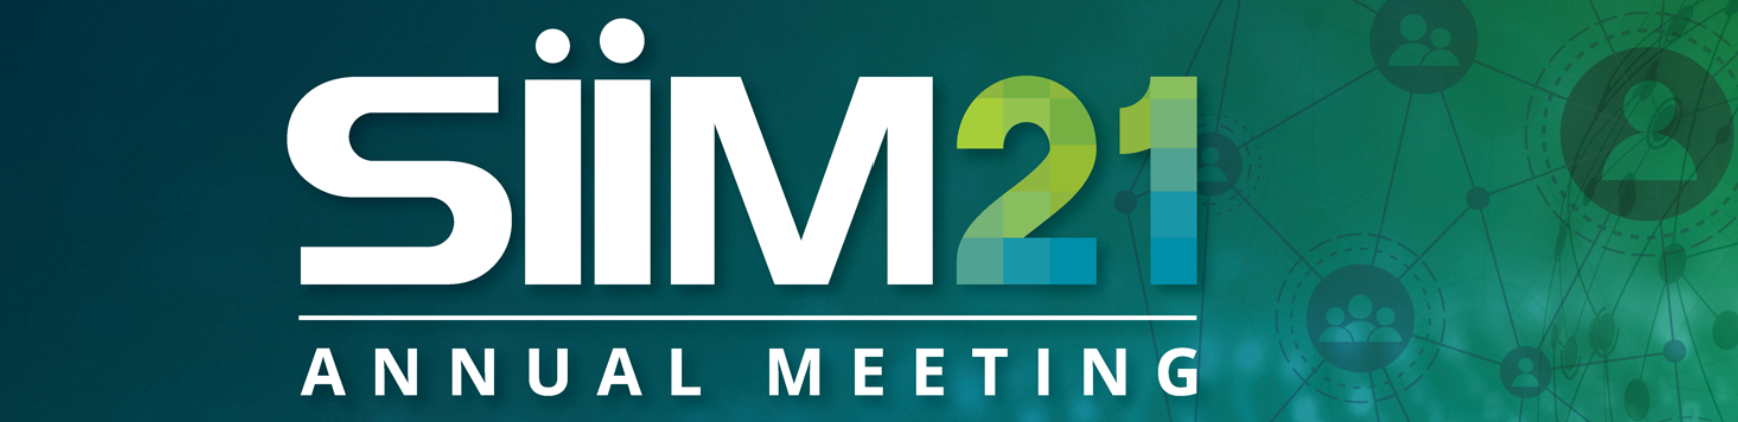

# Preprocessing Pathology Whole Slide Images for Segmentation


### Task

In this notebook we will generate the dataset that can be used to train a model to segment glomeruli in kidney biopsy images.

Unfortunately, we can't use Whole Slide Images as an input to our CNN (average of 40,000 x 40,000 pixels), due to limitations in current computational power. Thus, we need to split the WSI into small patches.

### Requirements

- Programming in Python
- 100GB storage

### Learning Objectives:
 
By the end of this activity, you will be able to:

- Understand the running length encoding (RLE) format for segmentation masks
- Convert RLE to mask
- Open gigapixel whole slide pathology images (WSI)
- Convert WSIs and their corresponding masks into tiles


### Dataset

The dataset we will use as example is from a Kaggle Challenge (HubMap) and can be downloaded at: https://www.kaggle.com/c/hubmap-kidney-segmentation/data. 

The images are in .tiff format and segmentation masks are compressed in rle format in a .csv file.

Make sure you download the dataset (30.71GB), unzip it, and execute this Juypter Notebook from within the dataset folder where you can access the train/ folder and the train.csv file.

### Acknowledgements

This Jupyter Notebook was based on code by João Pedro Mazuco Rodriguez (joaopedromrodriguez@gmail.com), modified by Felipe Kitamura (kitamura.felipe@gmail.com).

##### 1. Importing libraries

In [ ]:
import cv2
import PIL
import numpy as np
from PIL import Image
import os  
import json
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import seaborn as sn
from pathlib import Path

##### 2. Configuring PIL and creating folders

In [ ]:
#Setting a config of PIL due to the large size of WSIs
PIL.Image.MAX_IMAGE_PIXELS = 933120000

#Creating folders for our dataset
Path("dataset").mkdir(parents=True, exist_ok=True)
Path("dataset/Patch").mkdir(parents=True, exist_ok=True)
Path("dataset/Label").mkdir(parents=True, exist_ok=True)

##### 3. Defining a function to convert RLE to mask

RLE is a way to compress binary masks. Instead of saving each pixel, we save "pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3)... The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc." (https://www.kaggle.com/c/hubmap-kidney-segmentation/overview/supervised-ml-evaluation)





In [1]:
#Function that decode RLE to mask (https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode)
def rle2mask(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

##### 4. Showtime. Let's convert WSI and corresponding masks to tiles

In [ ]:
# Get all the slides filenames from the train dataset

slides = [x for x in os.listdir("train/") if '.tiff' in x]

#For each slide...
for slide in slides:
    print(slide)
    print("Running...") #This can take a while...
    
    #Read the slide
    im = tifffile.imread(os.path.join(slide))

    #These conditions deal with some exotic image shapes
    if(im.shape[0]==1 and im.shape[1]==1):
        im = im[0][0]
    if(im.shape[0]==3):
        im = np.moveaxis(im, 0, -1)

    #Read the mask from .csv file
    train_mask = pd.read_csv("train.csv")
    
    #Decode RLE to Mask
    mask = rle2mask(
        train_mask[train_mask["id"] == str(slide)]["encoding"].values[0], 
        (im.shape[1], im.shape[0])
    )

    #Transform each mask in a grayscale image
    mask = mask*255;

    #Now we're going to divide the WSI in small patches
    #Only patches with tissue are going to be selected

    #First, we define the patch size (patchSize x patchSize pixels)
    patchSize = 256

    #Then, we define the stride value.
    #If you wanna use overlap as a data augmentation
    #you can decrease this value
    stride = 256

    #Now we iterate the WSI to get small patches
    for patch_row in range(0,im.shape[1]-patchSize, 256):
        for patch_column in range(0, im.shape[0]-patchSize, 256):

            #Selecting a patch from the WSI
            imgPatch = im[patch_column:patch_column+patchSize, patch_row:patch_row+patchSize]
            
            #Getting the mask from the same position
            maskPatch = mask[patch_column:patch_column+patchSize, patch_row:patch_row+patchSize]
            
            #Some adjustments in the color channels...
            img = cv2.cvtColor(np.array(imgPatch), cv2.COLOR_RGB2BGR)
            
            #Creating a mask to do the tissue segmentation:
            #First, we only take the pixels with tissue,
            #excluding black pixels (below (10, 10, 10) in RGB)
            #and white pixels (above (200,200,200) in RGB)
            mask_background = cv2.inRange(img, (10,10,10), (200,200,200))
            
            #Then, we count how many pixels have tissue
            tissuePixels = cv2.countNonZero(mask_background)

            #If the patch has at least 5% of tissue...
            if(tissuePixels>patchSize**2*0.05):
                #Save inside dataset folder
                #The patches
                cv2.imwrite('dataset/Patch/'+'patch'+str(index)+'_'+str(patch_row)+'_'+str(patch_column)+'.png', img)
                #And their respective mask
                cv2.imwrite('dataset/Label/'+'patch'+str(index)+'_'+'_'+str(patch_row)+'_'+str(patch_column)+'.png', maskPatch)

##### 5. Check the result

Go to dataset/Patch folder to see the patches and to dataset/Label to see the corresponding masks. By pairing the patches and labels with the same filenames you shoud be able to see images like the ones below:

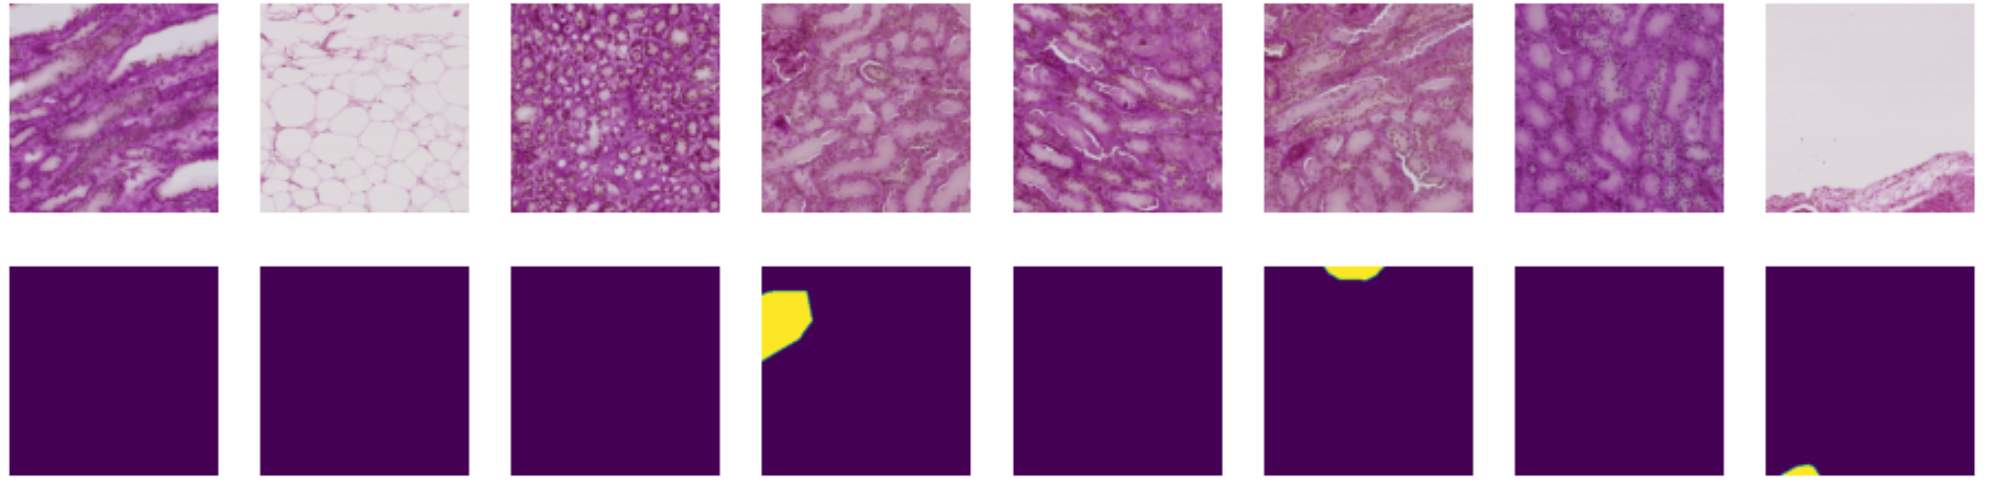

The masks correspond to areas where there are glomeruli.